### Importing Necessary Libraries

In [68]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.models import load_model

In [46]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing & Opening the data 

In [47]:
# Load the dataset
netcdf_file_path = "Data/final_SSC_Data.nc"

# Open the data using xarray
dataset = xr.open_dataset(netcdf_file_path)

### Converting Dataframe to Pandas, Dropping uneccessary Columns & nans

In [48]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Drop rows where either 'u' or 'v' (or both) have NaN values
df.dropna(subset=['u', 'v'], inplace=True)

df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

df

,time,lat,lon,u,v
time,,,,,
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,14.5692,0.224436,-0.204129
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,14.6097,0.225030,-0.220144
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,14.6503,0.219380,-0.229340
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,14.6908,0.192193,-0.223198
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,15.0965,-0.088404,-0.160217
...,...,...,...,...,...
2023-08-01 23:00:00,2023-08-01 23:00:00,36.880199,14.0419,-0.179297,-0.109355
2023-08-01 23:00:00,2023-08-01 23:00:00,36.880199,14.0824,-0.187970,-0.150195
2023-08-01 23:00:00,2023-08-01 23:00:00,36.880199,14.1230,-0.184672,-0.175530


### Geospatial Visualization
Define boundaries and coordinates for visualization

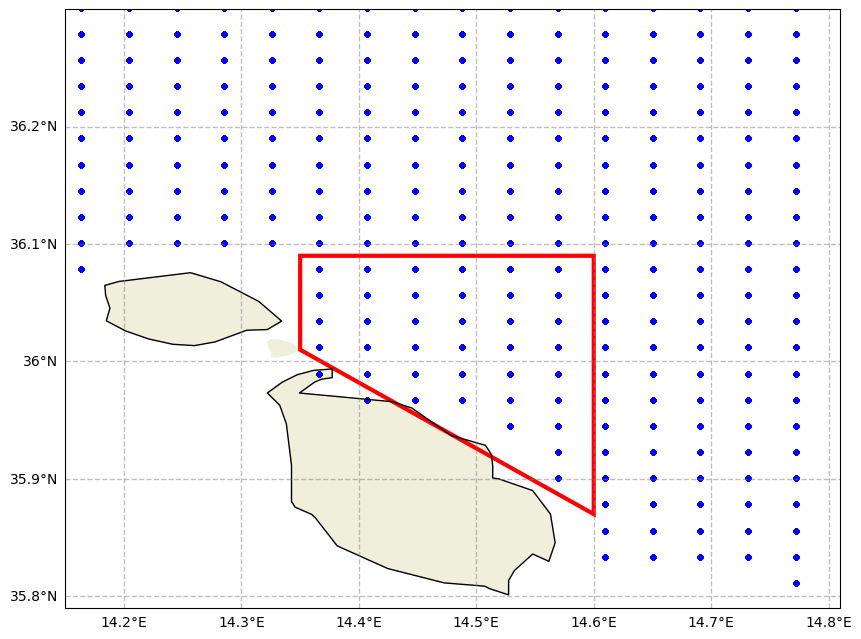

In [49]:
# Define the boundaries for map
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.81,  
    'min_lat': 35.79,  
    'max_lat': 36.3   
}

# Define the coordinates 
polygon_coordinates = [
    (14.6, 35.87), 
    (14.35, 36.01), 
    (14.35, 36.09), 
    (14.6, 36.09), 
    (14.6, 35.87)
]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting all points within the boundary from the dataframe 'df'
ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Create a red polygon and add it to the plot
red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
ax.add_patch(red_polygon)

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

### Data Filtering 
Filter the DataFrame to include only data points within the specified polygon.

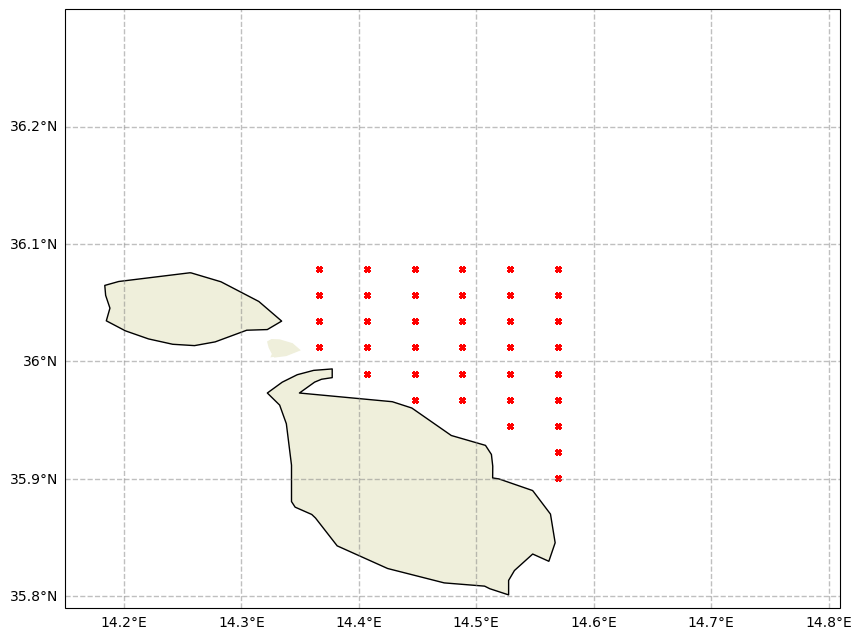

In [50]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Use the Path object to find points inside the polygon
inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
df_inside_polygon = df[inside_polygon]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plotting only the points within the polygon
ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic())

# Gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

### Selecting the coordinates inside the polygon

In [51]:
# Convert the polygon coordinates to a Path object
polygon_path = mpath.Path(polygon_coordinates)

# Prepare the coordinates as a list of tuples
coordinates = list(zip(df['lon'], df['lat']))

# Check if each coordinate is inside the polygon
inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# Filter the DataFrame for points within the polygon
df_inside_polygon = df[inside_mask]

# Removing potential duplicates
df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# Count the number of points inside the polygon
num_points_inside_polygon = df_inside_polygon.shape[0]
print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
print("Coordinates of the points inside the polygon:")

# Print out all of the coordinate pairs
coordinates_inside = df_inside_polygon[['lon', 'lat']].values
for lon, lat in coordinates_inside:
    print(f"({lon}, {lat})")

Total number of points inside the polygon: 37

Coordinates of the points inside the polygon:
(14.569199562072754, 35.90060043334961)
(14.569199562072754, 35.92279815673828)
(14.569199562072754, 35.945098876953125)
(14.528599739074707, 35.96730041503906)
(14.569199562072754, 35.96730041503906)
(14.447500228881836, 35.989601135253906)
(14.48799991607666, 35.989601135253906)
(14.528599739074707, 35.989601135253906)
(14.569199562072754, 35.989601135253906)
(14.447500228881836, 36.01190185546875)
(14.48799991607666, 36.01190185546875)
(14.528599739074707, 36.01190185546875)
(14.569199562072754, 36.01190185546875)
(14.447500228881836, 36.03409957885742)
(14.48799991607666, 36.03409957885742)
(14.528599739074707, 36.03409957885742)
(14.569199562072754, 36.03409957885742)
(14.447500228881836, 36.056400299072266)
(14.48799991607666, 36.056400299072266)
(14.528599739074707, 36.056400299072266)
(14.569199562072754, 36.056400299072266)
(14.366399765014648, 36.07870101928711)
(14.406900405883789, 3

### Creating a Data Frame for the coordinates inside the polygon

In [52]:
# Convert 'inside_mask' to a pandas Series to use as a boolean indexer
inside_series = pd.Series(inside_mask, index=df.index)

# Filter the original DataFrame using the boolean Series
final_df = df[inside_series]

# Display the loaded DataFrame
final_df

,time,lat,lon,u,v
time,,,,,
2020-02-25 15:00:00,2020-02-25 15:00:00,35.900600,14.5692,0.224436,-0.204129
2020-02-25 15:00:00,2020-02-25 15:00:00,35.922798,14.5692,0.209744,-0.180382
2020-02-25 15:00:00,2020-02-25 15:00:00,35.945099,14.5692,0.165433,-0.158304
2020-02-25 15:00:00,2020-02-25 15:00:00,35.967300,14.5286,0.139062,-0.155931
2020-02-25 15:00:00,2020-02-25 15:00:00,35.967300,14.5692,0.162474,-0.140758
...,...,...,...,...,...
2023-08-01 23:00:00,2023-08-01 23:00:00,36.078701,14.4069,0.148599,-0.234722
2023-08-01 23:00:00,2023-08-01 23:00:00,36.078701,14.4475,0.153244,-0.216512
2023-08-01 23:00:00,2023-08-01 23:00:00,36.078701,14.4880,0.165081,-0.183771


### Filtering for specific coordinates

In [54]:
# Directory to save the files, ensure it exists
save_directory = "Data/coordinate_data_frames"

# Coordinates of the points inside the polygon
coordinates_inside = [
    (14.569199562072754, 35.90060043334961),
    (14.569199562072754, 35.92279815673828),
    (14.569199562072754, 35.945098876953125),
    # (14.528599739074707, 35.96730041503906),
    # (14.569199562072754, 35.96730041503906),
    # (14.447500228881836, 35.989601135253906),
    # (14.48799991607666, 35.989601135253906),
    # (14.528599739074707, 35.989601135253906),
    # (14.569199562072754, 35.989601135253906),
    # (14.447500228881836, 36.01190185546875),
    # (14.48799991607666, 36.01190185546875),
    # (14.528599739074707, 36.01190185546875),
    # (14.569199562072754, 36.01190185546875),
    # (14.447500228881836, 36.03409957885742),
    # (14.48799991607666, 36.03409957885742),
    # (14.528599739074707, 36.03409957885742),
    # (14.569199562072754, 36.03409957885742),
    # (14.447500228881836, 36.056400299072266),
    # (14.48799991607666, 36.056400299072266),
    # (14.528599739074707, 36.056400299072266),
    # (14.569199562072754, 36.056400299072266),
    # (14.366399765014648, 36.07870101928711),
    # (14.406900405883789, 36.07870101928711),
    # (14.447500228881836, 36.07870101928711),
    # (14.48799991607666, 36.07870101928711),
    # (14.528599739074707, 36.07870101928711),
    # (14.569199562072754, 36.07870101928711),
    # (14.528599739074707, 35.945098876953125),
    # (14.406900405883789, 36.03409957885742),
    # (14.406900405883789, 36.056400299072266),
    # (14.406900405883789, 36.01190185546875),
    # (14.366399765014648, 36.03409957885742),
    # (14.366399765014648, 36.056400299072266),
    # (14.48799991607666, 35.96730041503906),
    # (14.406900405883789, 35.989601135253906,),
    # (14.366399765014648, 36.01190185546875),
    # (14.447500228881836, 35.96730041503906)
]

# Loop through each pair of coordinates along with an index
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Debug: Print the current pair being processed
    print(f"Processing pair {index}: (lat: {lat}, lon: {lon})")

    # Filter the DataFrame for the exact coordinates
    df_point = final_df[(final_df['lat'] == lat) & (final_df['lon'] == lon)]

    # Debug: Check if any data points were found for the current pair
    if df_point.empty:
        print(f"No data points found for (lat: {lat}, lon: {lon})")
    else:
        print(f"Found {df_point.shape[0]} data points for (lat: {lat}, lon: {lon})")

    # Format the latitude and longitude to remove periods
    lat_formatted = str(lat).replace('.', '_')
    lon_formatted = str(lon).replace('.', '_')

    # Create a unique filename for each pair of coordinates
    filename = f"{index}_{lat_formatted}_{lon_formatted}.csv"
    filepath = os.path.join(save_directory, filename)

    # Save the filtered DataFrame to a CSV file
    df_point.to_csv(filepath, index=False)

    # Confirm that the file has been saved
    print(f"Saved data for (lat: {lat}, lon: {lon}) as {filename}\n")

print("\nAll data processing complete.")
print("="*175)

Processing pair 1: (lat: 35.90060043334961, lon: 14.569199562072754)
Found 6694 data points for (lat: 35.90060043334961, lon: 14.569199562072754)
Saved data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35_90060043334961_14_569199562072754.csv

Processing pair 2: (lat: 35.92279815673828, lon: 14.569199562072754)
Found 6804 data points for (lat: 35.92279815673828, lon: 14.569199562072754)
Saved data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35_92279815673828_14_569199562072754.csv

Processing pair 3: (lat: 35.945098876953125, lon: 14.569199562072754)
Found 8293 data points for (lat: 35.945098876953125, lon: 14.569199562072754)
Saved data for (lat: 35.945098876953125, lon: 14.569199562072754) as 3_35_945098876953125_14_569199562072754.csv


All data processing complete.


### Main loop (pre-processing and train)

Processing file: 1_35_90060043334961_14_569199562072754.csv

Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0802INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 86s 1s/step - loss: 0.0103 - mean_absolute_error: 0.0802 - val_loss: 0.0110 - val_mean_absolute_error: 0.0787
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0664INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 80s 1s/step - loss: 0.0076 - mean_absolute_error: 0.0664 - val_loss: 0.0074 - val_mean_absolute_error: 0.0606
Epoch 3/100
73/73 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0556INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 80s 1s/step - loss: 0.0056 - mean_absolute_error: 0.0556 - val_loss: 0.0066 - val_mean_absolute_error: 0.0542
Epoch 4/100
73/73 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0491INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 66s 912ms/step - loss: 0.0047 - mean_absolute_error: 0.0491 - val_loss: 0.0056 - val_mean_absolute_error: 0.0477
Epoch 5/100
73/73 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0444INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 74s 1s/step - loss: 0.0040 - mean_absolute_error: 0.0444 - val_loss: 0.0050 - val_mean_absolute_error: 0.0439
Epoch 6/100
73/73 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0415INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 76s 1s/step - loss: 0.0037 - mean_absolute_error: 0.0415 - val_loss: 0.0046 - val_mean_absolute_error: 0.0410
Epoch 7/100
73/73 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0389INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 83s 1s/step - loss: 0.0033 - mean_absolute_error: 0.0389 - val_loss: 0.0044 - val_mean_absolute_error: 0.0393
Epoch 8/100
73/73 [==============================] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0371INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_1_35_90060043334961_14_569199562072754\assets


73/73 [==============================] - 74s 1s/step - loss: 0.0032 - mean_absolute_error: 0.0371 - val_loss: 0.0043 - val_mean_absolute_error: 0.0385
Epoch 9/100
73/73 [==============================] - 63s 869ms/step - loss: 0.0031 - mean_absolute_error: 0.0362 - val_loss: 0.0044 - val_mean_absolute_error: 0.0384
Epoch 10/100
73/73 [==============================] - 64s 875ms/step - loss: 0.0031 - mean_absolute_error: 0.0361 - val_loss: 0.0045 - val_mean_absolute_error: 0.0390
Epoch 11/100
73/73 [==============================] - 64s 872ms/step - loss: 0.0031 - mean_absolute_error: 0.0364 - val_loss: 0.0044 - val_mean_absolute_error: 0.0384
Training stopped at epoch: 8
Best validation loss achieved at epoch: 8


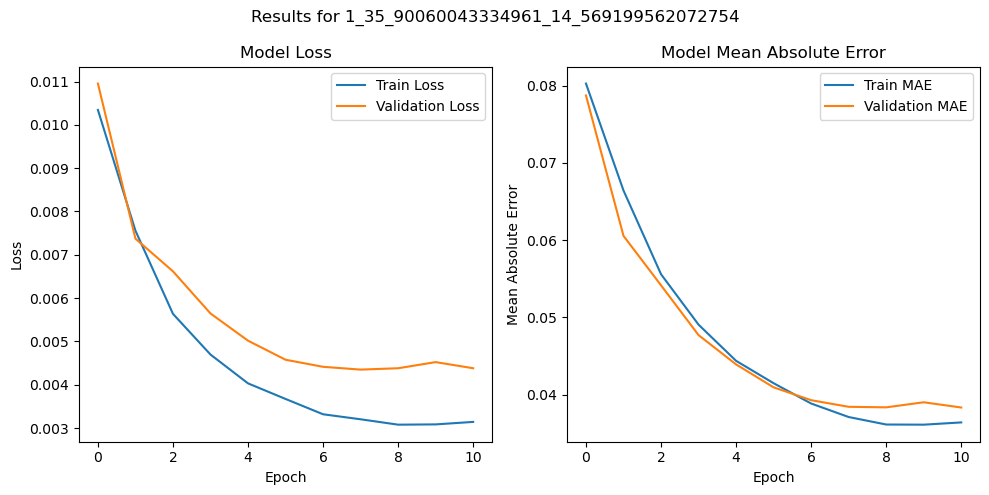

15/15 [==============================] - 3s 152ms/step
File: 1_35_90060043334961_14_569199562072754.csv
Mean Squared Error (MSE): 0.002844503920122846
Mean Absolute Error (MAE): 0.03375579744091077
Root Mean Squared Error (RMSE): 0.05333389091490369


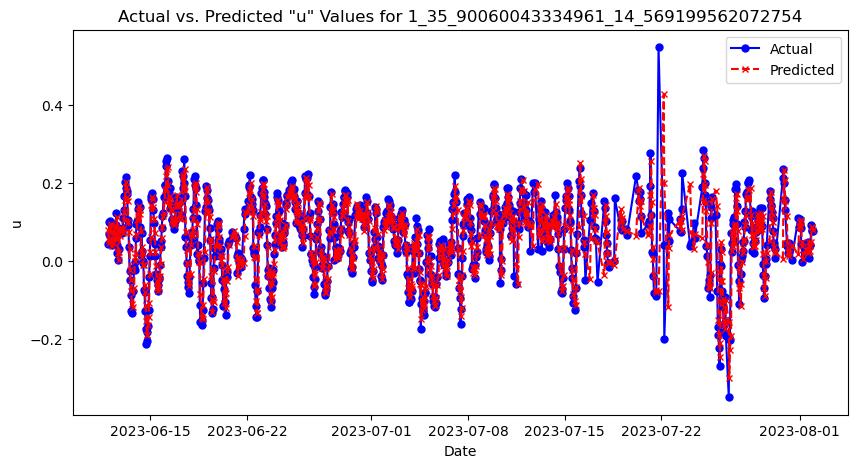

Model tarining & evaluation completed for file: 1_35_90060043334961_14_569199562072754.csv

Processing file: 2_35_92279815673828_14_569199562072754.csv

Epoch 1/100
74/74 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0807INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 79s 1s/step - loss: 0.0103 - mean_absolute_error: 0.0807 - val_loss: 0.0110 - val_mean_absolute_error: 0.0811
Epoch 2/100
74/74 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0643INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 93s 1s/step - loss: 0.0070 - mean_absolute_error: 0.0643 - val_loss: 0.0071 - val_mean_absolute_error: 0.0593
Epoch 3/100
74/74 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0532INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 141s 2s/step - loss: 0.0051 - mean_absolute_error: 0.0532 - val_loss: 0.0057 - val_mean_absolute_error: 0.0498
Epoch 4/100
74/74 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0461INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 151s 2s/step - loss: 0.0041 - mean_absolute_error: 0.0461 - val_loss: 0.0050 - val_mean_absolute_error: 0.0442
Epoch 5/100
74/74 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.0412INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 151s 2s/step - loss: 0.0035 - mean_absolute_error: 0.0412 - val_loss: 0.0048 - val_mean_absolute_error: 0.0413
Epoch 6/100
74/74 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0394INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


INFO:tensorflow:Assets written to: Data/saved_models\model_2_35_92279815673828_14_569199562072754\assets


74/74 [==============================] - 148s 2s/step - loss: 0.0033 - mean_absolute_error: 0.0394 - val_loss: 0.0048 - val_mean_absolute_error: 0.0403
Epoch 7/100
74/74 [==============================] - 133s 2s/step - loss: 0.0031 - mean_absolute_error: 0.0374 - val_loss: 0.0049 - val_mean_absolute_error: 0.0400
Epoch 8/100
74/74 [==============================] - 140s 2s/step - loss: 0.0031 - mean_absolute_error: 0.0371 - val_loss: 0.0048 - val_mean_absolute_error: 0.0396
Epoch 9/100
74/74 [==============================] - 103s 1s/step - loss: 0.0031 - mean_absolute_error: 0.0366 - val_loss: 0.0048 - val_mean_absolute_error: 0.0395
Training stopped at epoch: 6
Best validation loss achieved at epoch: 6


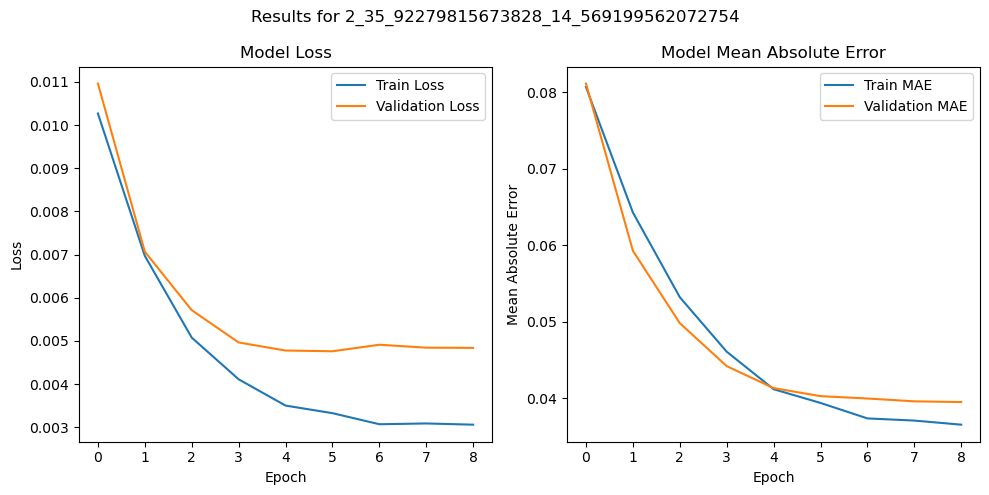

15/15 [==============================] - 6s 336ms/step
File: 2_35_92279815673828_14_569199562072754.csv
Mean Squared Error (MSE): 0.002618811889251461
Mean Absolute Error (MAE): 0.03458751683178384
Root Mean Squared Error (RMSE): 0.05117432842013133


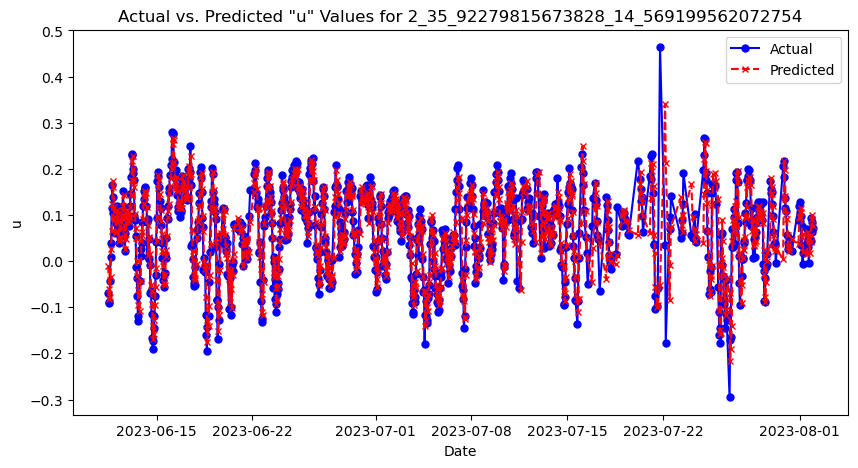

Model tarining & evaluation completed for file: 2_35_92279815673828_14_569199562072754.csv



In [58]:
model_save_directory = "Data/saved_models" 

# List all CSV files in the directory
csv_files = [f for f in os.listdir(save_directory) if f.endswith('.csv')]

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# Loop through each CSV file
for file in csv_files:
    print("="*175)
    print(f"Processing file: {file}\n")

    # Load the dataset
    df = pd.read_csv(os.path.join(save_directory, file))

    # Convert the 'time' column to datetime object and set it as the index
    df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
    df.set_index('time', inplace=True)

    # Select 'u' and 'v' columns as input features
    df_input = df[['u', 'v']]
    features = df_input.to_numpy()

    # Set the first column as the target variable
    target = df_input['u'].values

    # Splitting Data into Train, Validation, and Test sets
    X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, shuffle=False)

    # Time series generator parameters
    win_length = 72 # 3 Days
    batch_size = 64
    num_features = 2

    # Creating time series generators
    train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
    val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
    test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

    # Building the LSTM Model
    model = Sequential([
        LSTM(256, input_shape=(win_length, num_features), return_sequences=True),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])

    # Compile the model
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[MeanAbsoluteError()])

    # Define ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(filepath=f"{model_save_directory}/model_{file[:-4]}", save_best_only=True, monitor='val_loss', mode='min', verbose=0)

    # Fit the model
    history = model.fit(train_generator, epochs=100, validation_data=val_generator, shuffle=False, callbacks=[early_stopping, model_checkpoint])

    # Determine the epoch number at best performance
    best_epoch = early_stopping.stopped_epoch - early_stopping.patience

    print("="*175)
    print(f"Training stopped at epoch: {best_epoch + 1}")
    print(f"Best validation loss achieved at epoch: {best_epoch + 1}\n")

    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training & validation mean absolute error values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.suptitle(f'Results for {file[:-4]}')
    plt.tight_layout()
    plt.show()

    # Generate predictions for the test data
    predictions = model.predict(test_generator)
    test_indexes = df.index[-len(predictions):]

    # Preparing the final DataFrame for plotting and analysis
    df_final = pd.DataFrame(df.loc[test_indexes])
    df_final['u_pred'] = predictions.flatten()

    # Calculate metrics
    mse = mean_squared_error(df_final['u'], df_final['u_pred'])
    mae = mean_absolute_error(df_final['u'], df_final['u_pred'])
    rmse = np.sqrt(mse)

    print(f'File: {file[:-4]}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    # Plot Actual vs. Predicted 'u' Values
    plt.figure(figsize=(10, 5))
    plt.plot(df_final.index, df_final['u'], label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
    plt.plot(df_final.index, df_final['u_pred'], label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
    plt.title(f'Actual vs. Predicted "u" Values for {file[:-4]}')  
    plt.xlabel('Date') 
    plt.ylabel('u')
    plt.legend()
    plt.show()

    print("="*175)
    print(f"Model tarining & evaluation completed for file: {file}")
    print("="*175, "\n")

## Making a real life Prediction

### Extracting 3 days for inputs from every pair of coordinates

In [66]:
# Load the dataset (August 1, 2023 till August 3, 2023)
input_netcdf_path = "Data/3_day_input_SSC_Data.nc"
dataset = xr.open_dataset(input_netcdf_path)

# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Directory to save the files
input_save_directory = "Data/3_day_input_data_frames"
os.makedirs(input_save_directory, exist_ok=True) 

# Loop through each pair of coordinates
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Extract data for the specific coordinates and explicitly copy it
    df_specific = df[(df['lat'] == lat) & (df['lon'] == lon)].copy()

    # Ensure the DataFrame is sorted by time
    df_specific.sort_values('time', inplace=True)

    # Interpolate NaN values using cubic spline interpolation
    df_specific.loc[:, ['u', 'v']] = df_specific[['u', 'v']].interpolate(method='spline', order=3)

    # After interpolation, if there are still NaNs at the beginning or the end, fill them
    df_specific.loc[:, ['u', 'v']] = df_specific[['u', 'v']].fillna(method='bfill').fillna(method='ffill')

    # Save to CSV file
    filename = f"{index}_{lat}_{lon}_3_day.csv"
    filepath = os.path.join(input_save_directory, filename)
    df_specific.to_csv(filepath, index=False)
    print(f"Saved 3-day data for (lat: {lat}, lon: {lon}) as {filename}")

Saved 3-day data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35.90060043334961_14.569199562072754_3_day.csv
Saved 3-day data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35.92279815673828_14.569199562072754_3_day.csv
Saved 3-day data for (lat: 35.945098876953125, lon: 14.569199562072754) as 3_35.945098876953125_14.569199562072754_3_day.csv


### Extracting 1 day for comparison from every pair of coordinates

In [67]:
# Load the dataset (August 4th, 2023)
actual_netcdf_path = "Data/1_day_actual_4th_SSC_Data.nc"
actual_dataset = xr.open_dataset(actual_netcdf_path)

# Convert the dataset to a pandas DataFrame and reset index
actual_df = actual_dataset.to_dataframe().reset_index()

# Drop unnecessary columns from the DataFrame
actual_df = actual_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Directory to save the files
actual_save_directory = "Data/1_day_actual_data_frames"
os.makedirs(actual_save_directory, exist_ok=True)

# Loop through each pair of coordinates
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    # Extract data for the specific coordinates and explicitly copy it
    actual_df_specific = actual_df[(actual_df['lat'] == lat) & (actual_df['lon'] == lon)].copy()

    # Ensure the DataFrame is sorted by time
    actual_df_specific.sort_values('time', inplace=True)

    # Interpolate NaN values using cubic spline interpolation
    actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].interpolate(method='spline', order=3)

    # After interpolation, if there are still NaNs at the beginning or the end, fill them
    actual_df_specific.loc[:, ['u', 'v']] = actual_df_specific[['u', 'v']].fillna(method='bfill').fillna(method='ffill')

    # Save to CSV file
    filename = f"{index}_{lat}_{lon}_1_day.csv"
    filepath = os.path.join(actual_save_directory, filename)
    actual_df_specific.to_csv(filepath, index=False)
    print(f"Saved 1-day actual data for (lat: {lat}, lon: {lon}) as {filename}")

Saved 1-day actual data for (lat: 35.90060043334961, lon: 14.569199562072754) as 1_35.90060043334961_14.569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.92279815673828, lon: 14.569199562072754) as 2_35.92279815673828_14.569199562072754_1_day.csv
Saved 1-day actual data for (lat: 35.945098876953125, lon: 14.569199562072754) as 3_35.945098876953125_14.569199562072754_1_day.csv


### Rolling Prediction for 24 hours

In [69]:
# Number of hours to predict into the future
n_future_hours = 24

# Process each pair of coordinates
for index, (lon, lat) in enumerate(coordinates_inside, start=1):
    model_filepath = os.path.join(model_save_directory, f"model_{index}_{lat}_{lon}")
    input_csv_filepath = os.path.join(input_save_directory, f"{index}_{lat}_{lon}_3_day.csv")
    actual_csv_filepath = os.path.join(actual_save_directory, f"{index}_{lat}_{lon}_1_day.csv")

    # Check if model and data files exist
    if os.path.exists(model_filepath) and os.path.exists(input_csv_filepath) and os.path.exists(actual_csv_filepath):
        # Load model
        model = load_model(model_filepath)

        # Load and prepare input data
        input_df = pd.read_csv(input_csv_filepath)
        input_df.sort_values('time', inplace=True)
        input_features = input_df[['u', 'v']].values

        # Ensure there is enough data for predictions
        if len(input_features) >= win_length:
            predictions = []
            last_input_features = input_features[-win_length:].reshape(1, win_length, num_features)

            # Generate rolling predictions for the next 24 hours
            for _ in range(n_future_hours):
                # Generate prediction for the next time step
                current_prediction = model.predict(last_input_features, verbose=0)[0, 0]
                predictions.append(current_prediction)

                # Update the data window for the next prediction
                last_input_features = np.append(last_input_features[:, 1:, :], [[input_features[win_length - 1]]], axis=1)

            # Load and prepare actual data for comparison
            actual_df = pd.read_csv(actual_csv_filepath)
            actual_df.sort_values('time', inplace=True)
            actual_u_values = actual_df['u'].values[:n_future_hours]

            # Compute metrics
            mae = mean_absolute_error(actual_u_values, predictions)
            mse = mean_squared_error(actual_u_values, predictions)
            rmse = np.sqrt(mse)

            # Output the metrics
            print(f'Coordinates {lat}, {lon}:')
            print(f'  MAE: {mae:.6f}')
            print(f'  MSE: {mse:.6f}')
            print(f'  RMSE: {rmse:.6f}\n')
        else:
            print(f'Not enough input data for predictions at lat {lat}, lon {lon}\n')
    else:
        print(f'Missing data or model for lat {lat}, lon {lon}\n')

Missing data or model for lat 35.90060043334961, lon 14.569199562072754

Missing data or model for lat 35.92279815673828, lon 14.569199562072754

Missing data or model for lat 35.945098876953125, lon 14.569199562072754

